In [1]:
import pandas as pd
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import seaborn as sns


# Lighting area: exploration and questions

**30/09/2022 | Elizaveta Bakaeva**<br>

## Task overview
Explore and describe the information contained in the sample dataset made available for download here in simple phrases, including any limitations you wish to highlight. Supporting material is provided in the documentation folder.

Questions (sent to you via Slack by the EM)

- Do Creators experience any errors when using our Lighting tools?
- How many Creators use “bakeBackend”?
- Which version of “bakeBackend” is used the most?
- How many Creators use the Menu button in the Unity Editor to find our Lighting tools?
- What is the preferred Lightmap size?

## Data assumptions
* Sample data is quite huge - at least 1mln columns.
* ID is an indentificator of a user. But it contains 22163 nulled rows -> before reporting any numbers regarding users I should mention it
* Each ID has at least one session -> maximum is 293 sessions per user
* There are columns that are not relevant to the questions asked
* Parameters can be split into additional columns, and they contain the data directly related to questions

## Plan

* Clean dataset -> remove nulls in user values (save them for later, maybe it will be possible to consider that each session id referes to 1 user)
* Perform EDA
* Transform parameters columns into a separate dataset
* Make up groupby tables to answer EM questions

Load JSON
====

In [2]:
%cd ..

/Users/ebakaeva/Documents/GitHub/take-home-exercise-SR-data-analyst


In [3]:
ROOT_DIR = os.path.abspath('')
data_path = os.path.join(ROOT_DIR, 'data', 'data_zipped.json')

In [4]:
data=[]
for line in open(data_path):
    data.append(json.loads(line))

In [5]:
light_df=pd.DataFrame(data)

In [6]:
# checking size and being terrified by it 
light_df.shape

(1000100, 11)

In [7]:
# cheking for nulls
light_df.isnull().sum().sum()

55455

In [8]:
# checking for nulls in the column
light_df.isnull().sum()

submit_date        0
ID             22163
platform           0
sessionid          0
blocking           0
duration         143
parameters         0
start              0
subtype            0
ts               171
license        32978
dtype: int64

In [9]:
ind_na=light_df[light_df.ID.isna()==True].index
light_cleaned=light_df.drop(index=ind_na)

In [10]:
# constant value will not provide us with valuable results
light_cleaned.submit_date.unique()

array(['2021-10-28'], dtype=object)

In [11]:
# seems like the time columns are not in the scope of EM interest at the moment
# I am leaving formatting here, but will drop them for now
# light_cleaned.loc[:, 'start']=pd.to_datetime(light_cleaned.loc[:, 'start'], format='%Y-%m-%dT%H:%M:%S.%f%z')
# light_cleaned.loc[:, 'ts']=pd.to_datetime(light_cleaned.loc[:, 'ts'], utc=True)

In [12]:
light_cleaned=light_cleaned.drop(columns=['submit_date', 'start', 'ts'])

In [13]:
light_cleaned.columns

Index(['ID', 'platform', 'sessionid', 'blocking', 'duration', 'parameters',
       'subtype', 'license'],
      dtype='object')

Studying data
===

In [14]:
light_cleaned.shape

(977937, 8)

In [15]:
light_cleaned.sessionid.nunique()

115339

In [16]:
light_cleaned.ID.nunique()

75756

In [17]:
print('seessions per user: from {0} to {1}'.format(light_cleaned.groupby('ID').sessionid.nunique().min(), light_cleaned.groupby('ID').sessionid.nunique().max()))

seessions per user: from 1 to 293


In [18]:
print('subtypes per session: from {0} to {1}'.format(light_cleaned.groupby('sessionid').subtype.nunique().min(), light_cleaned.groupby('sessionid').subtype.nunique().max()))

subtypes per session: from 1 to 3


In [19]:
light_cleaned.platform.unique()

array(['WindowsEditor', 'OSXEditor', 'LinuxEditor'], dtype=object)

In [20]:
light_cleaned.parameters.unique()

array(['{"sourceView":"UnityEditor.Toolbar"}', '{"sourceView":""}',
       '{"sourceView":"UnityEditor.Toolbar","delayDuration":831698,"loadScenesDuration":642984,"updateSceneDuration":4117109}',
       ...,
       '{"autoGenerate":false,"bakeBackend":"progressivegpu","computeRealtime":false,"computeBaked":true,"lightmapResolution":40.0,"compressLightmaps":true,"lightmapSize":1024,"progressive":{"directSamples":512,"indirectSamples":512,"bounces":1,"prioritizeView":true},"outcome":"success","sourceView":"UnityEditor.LightingWindow"}',
       '{"autoGenerate":true,"bakeBackend":"progressivegpu","computeRealtime":false,"computeBaked":true,"lightmapResolution":15.0,"compressLightmaps":true,"lightmapSize":1024,"progressive":{"directSamples":32,"indirectSamples":256,"bounces":3,"prioritizeView":true,"minBounces":1},"outcome":"success","fallback":"none"}',
       '{"autoGenerate":false,"bakeBackend":"progressivecpu","computeRealtime":false,"computeBaked":true,"lightmapResolution":4.0,"compre

In [21]:
light_cleaned.columns

Index(['ID', 'platform', 'sessionid', 'blocking', 'duration', 'parameters',
       'subtype', 'license'],
      dtype='object')

## Data transformation

* parameters is another JSON filed
* can be spit per columns

In [22]:
sample=light_cleaned.sample(n=100).reset_index().drop(columns='index')

In [23]:
sample.loc[:, 'json_parameters']=sample.loc[:, 'parameters'].apply(lambda x: json.loads(x))

In [24]:
expanded=pd.concat([sample, pd.json_normalize(sample.loc[:, 'json_parameters'])], axis=1)

In [25]:
expanded.describe()

lightmapResolution  lightmapSize  progressive.directSamples  \
count            7.000000      7.000000                        9.0   
mean            23.714286    804.571429                       32.0   
std             15.380879    273.675512                        0.0   
min             10.000000    512.000000                       32.0   
25%             10.000000    512.000000                       32.0   
50%             16.000000   1024.000000                       32.0   
75%             40.000000   1024.000000                       32.0   
max             40.000000   1024.000000                       32.0   

       progressive.indirectSamples  progressive.bounces  indirectResolution  \
count                     9.000000                  9.0                 4.0   
mean                    420.000000                  2.0                 2.0   
std                     123.060961                  0.0                 0.0   
min                     256.000000                  2.0                 2.0   
25%                     256.000000                  2.0                 2.0   
50%                     500.000000                  2.0                 2.0   
75%                     500.000000                  2.0                 2.0   
max                     512.000000                  2.0                 2.0   

       delayDuration  loadScenesDuration  updateSceneDuration  \
count   8.500000e+01        8.500000e+01         8.500000e+01   
mean    8.712316e+05        7.837651e+05         3.948955e+06   
std     2.004007e+06        1.980147e+06         4.474723e+06   
min     1.175100e+04        0.000000e+00         0.000000e+00   
25%     1.998370e+05        0.000000e+00         1.260210e+06   
50%     3.357720e+05        0.000000e+00         3.065090e+06   
75%     5.494560e+05        5.701060e+05         4.961976e+06   
max     1.388913e+07        1.122817e+07         2.773991e+07   

       backupScenesDuration  domainReloadDuration  progressive.minBounces  
count             53.000000          5.300000e+01                     1.0  
mean           15909.018868          5.160616e+05                     2.0  
std           115819.405589          3.756985e+06                     NaN  
min                0.000000          0.000000e+00                     2.0  
25%                0.000000          0.000000e+00                     2.0  
50%                0.000000          0.000000e+00                     2.0  
75%                0.000000          0.000000e+00                     2.0  
max           843178.000000          2.735126e+07                     2.0

In [26]:
profile = ProfileReport(expanded, title="Pandas Profiling Report")
profile.to_notebook_iframe()

## In principle, profiling report can help us answer the questions below.
## But running it on such huge dataset will be painful 

In [27]:
#apply to full dataframe
light_cleaned=light_cleaned.reset_index().drop(columns='index')
light_cleaned.loc[:, 'json_parameters']=light_cleaned.loc[:, 'parameters'].apply(lambda x: json.loads(x))
expanded_full=pd.concat([light_cleaned, pd.json_normalize(light_cleaned.loc[:, 'json_parameters'])], axis=1)

Questions
===

Do Creators experience any errors when using our Lighting tools?
---

Fields of interest: parameters.outcome 

Definition: error - is any other outcome besides success


In [28]:
finished_ind=expanded_full[expanded_full.outcome.isna()==False].index
expanded_full.loc[finished_ind, 'error']=expanded_full.loc[finished_ind, 'outcome'].apply(lambda x: 0 if x == 'success' else 1)

<AxesSubplot:xlabel='error', ylabel='Probability'>

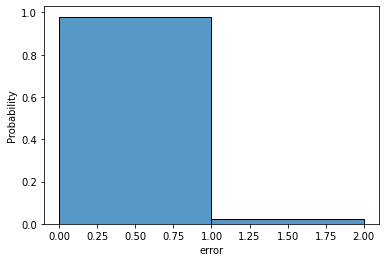

In [29]:
sns.histplot(data=expanded_full, x="error", stat="probability", bins=[0,1,2])

In [30]:
expanded_full['error'].value_counts(normalize=True)

0.0    0.979632
1.0    0.020368
Name: error, dtype: float64

In [31]:
ind_d=expanded_full[expanded_full.duration.isna()==False].index
expanded_full.loc[ind_d, 'duration']=expanded_full.loc[ind_d, 'duration'].astype(int)

In [32]:
def gr_by(column):
    pd.options.display.float_format = '{:,.2f}'.format
    gr=expanded_full.groupby(column).agg({'ID':'nunique', 'sessionid':'nunique'})
    gr_perc= gr.apply(lambda x: x/x.sum()).applymap(lambda x: "{:.0%}".format(x))
    return gr, gr_perc

In [33]:
gr_error, gr_perc_error=gr_by('error')

In [34]:
gr_error

ID  sessionid
error                  
0.00   14860      21236
1.00     590        731

In [35]:
gr_perc_error

ID sessionid
error               
0.00   96%       97%
1.00    4%        3%

Answer
---

If we define error as any unsuccessful outcome of baking process then yes, **users experience errors** during it.

The rate is quite small, however, around 3% of all sessions, and 4% of all users experience it

How many Creators use “bakeBackend”?
---

Fields of interest: parameters.bakeBackend 

Definition: use - there is at least one record  of such process per user 


In [36]:
expanded_full.bakeBackend.unique()

array([nan, 'enlighten', 'progressivecpu', 'progressivegpu'], dtype=object)

In [37]:
ind_b=expanded_full[expanded_full.bakeBackend.isna()==False].index

In [38]:
expanded_full.loc[ind_b, 'ID'].nunique()

15004

Answer
---


In [39]:
print('{:.0%} of users use bakeBackend'.format(expanded_full.loc[ind_b, 'ID'].nunique()/expanded_full.loc[:, 'ID'].nunique()))

20% of users use bakeBackend


Which version of “bakeBackend” is used the most?
---
Fields of interest: parameters.bakeBackend 

Version - backend used during the baking process

In [40]:
expanded_full['bakeBackend'].value_counts(normalize=True)

progressivecpu   0.71
enlighten        0.24
progressivegpu   0.04
Name: bakeBackend, dtype: float64

In [41]:
gr_back, gr_perc_back=gr_by('bakeBackend')

In [42]:
gr_back

ID  sessionid
bakeBackend                     
enlighten        4225       5888
progressivecpu  10789      15307
progressivegpu    593        755

In [43]:
gr_perc_back

ID sessionid
bakeBackend                  
enlighten       27%       27%
progressivecpu  69%       70%
progressivegpu   4%        3%

Answer
---

The most frequently used lightmapping backend is progressivecpu (most frequent for both, sessions and users, accountring up to 70% of total sessions/users **that use bakeBackend**)

How many Creators use the Menu button in the Unity Editor to find our Lighting tools?
---

Fields of interest: parameters.sourceView 

Menu button - source of baking initiation from GUI. 

Note: that does not mean that Lighting were found using this, the documentation state that they were initiated like this

In [44]:
ind_srs=expanded_full[expanded_full.sourceView.isna()==False].index
print('{:.0%} of users use sourceView'.format(expanded_full.loc[ind_srs, 'ID'].nunique()/expanded_full.loc[:, 'ID'].nunique()))

96% of users use sourceView


In [45]:
expanded_full.loc[ind_srs, 'ID'].nunique()

72476

In [46]:
gr_source, gr_perc_source=gr_by('sourceView')

In [47]:
ar=[]
for i in gr_source.index:
    if 'lighting' in i.lower() and 'unityeditor' in i.lower():
        ar.append(i)

In [48]:
ar

['UnityEditor.LightingWindow']

In [49]:
# note that there are records with blank space
gr_source.sort_values(by='ID', ascending=False)[:5]

ID  sessionid
sourceView                                           
UnityEditor.Toolbar                  67702      99074
                                      8820      12010
VRCSdkControlPanel                    4714       6614
UnityEditor.LightingWindow             794        920
UnityEditor.Recorder.RecorderWindow    318        376

In [50]:
gr_perc_source.sort_values(by='ID', ascending=False)[:5]

ID sessionid
sourceView                                     
UnityEditor.Toolbar               81%       83%
VRCSdkControlPanel                 6%        6%
                                  11%       10%
UnityEditor.LightingWindow         1%        1%
ProjectBILL.PlayTestEditorWindow   0%        0%

In [51]:
gr_source.loc[ar[0], :]

ID           794
sessionid    920
Name: UnityEditor.LightingWindow, dtype: int64

In [52]:
gr_perc_source.loc[ar[0], :]

ID           1%
sessionid    1%
Name: UnityEditor.LightingWindow, dtype: object

Answer
---

Menu button in the Unity Editor is used in **1%** of all baking initiations

What is the preferred Lightmap size?
--


Fields of interest: parameters.lightmapSize

In [53]:
ind_sz=expanded_full[expanded_full.lightmapSize.isna()==False].index
print('{:.0%} of users use lightmapSize'.format(expanded_full.loc[ind_sz, 'ID'].nunique()/expanded_full.loc[:, 'ID'].nunique()))

18% of users use lightmapSize


In [54]:
expanded_full.loc[ind_sz, 'ID'].nunique()

13274

In [55]:
gr_size, gr_perc_size=gr_by('lightmapSize')

In [56]:
gr_size.sort_values(by='ID', ascending=False)

ID  sessionid
lightmapSize                 
1,024.00      9255      12788
512.00        4181       5791
2,048.00       284        388
4,096.00        63         81
256.00          53         68
128.00          35         42
32.00           14         23
64.00            8          8

In [57]:
gr_perc_size.sort_values(by='ID', ascending=False)

ID sessionid
lightmapSize               
1,024.00      67%       67%
512.00        30%       30%
2,048.00       2%        2%
32.00          0%        0%
64.00          0%        0%
128.00         0%        0%
256.00         0%        0%
4,096.00       0%        0%

Answer
---

Preferred lightmapSize is **1,024**, which is used by **67%** of total users using lightmapSize